In [2]:
%%capture
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import polara
from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex

from dataprep import transform_indices
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items

from polara.lib.tensor import hooi
from polara.lib.sparse import tensor_outer_at
from polara.evaluation.pipelines import random_grid

from sa_hooi import sa_hooi, form_attention_matrix, get_scaling_weights, generate_position_projector

from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import norm, svds

from IPython.utils import io

# Data preparation

In [3]:
def full_preproccessing():
    data = get_movielens_data('ml-1m.zip', include_time=True)
    test_timepoint = data['timestamp'].quantile(
    q=0.8, interpolation='nearest'
    )

    test_data_ = data.query('timestamp >= @test_timepoint')
    train_data_ = data.query(
    'userid not in @test_data_.userid.unique() and timestamp < @test_timepoint'
    )
    
    training, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')
    test_data = reindex(test_data_, data_index['items'])

    testset_, holdout_ = leave_one_out(
    test_data, target='timestamp', sample_top=True, random_state=0
    )
    testset_valid_, holdout_valid_ = leave_one_out(
        testset_, target='timestamp', sample_top=True, random_state=0
    )

    test_users_val = np.intersect1d(testset_valid_.userid.unique(), holdout_valid_.userid.unique())
    testset_valid = testset_valid_.query('userid in @test_users_val').sort_values('userid')
    holdout_valid = holdout_valid_.query('userid in @test_users_val').sort_values('userid')

    test_users = np.intersect1d(testset_.userid.unique(), holdout_.userid.unique())
    testset = testset_.query('userid in @test_users').sort_values('userid')
    holdout = holdout_.query('userid in @test_users').sort_values('userid')


    assert holdout_valid.set_index('userid')['timestamp'].ge(
        testset_valid
        .groupby('userid')
        ['timestamp'].max()
    ).all()
    
    assert holdout.set_index('userid')['timestamp'].ge(
        testset
        .groupby('userid')
        ['timestamp'].max()
    ).all()

    data_description = dict(
        users = data_index['users'].name,
        items = data_index['items'].name,
        feedback = 'rating',
        n_users = len(data_index['users']),
        n_items = len(data_index['items']),
        n_ratings = training['rating'].nunique(),
        min_rating = training['rating'].min()
    )

    return training, testset_valid, holdout_valid, testset, holdout, data_description

In [4]:
training, testset_valid, holdout_valid, testset, holdout, data_description = full_preproccessing()

Filtered 177 invalid observations.


In [5]:
def make_prediction(tf_scores, holdout_valid, data_description):
    for n in [5, 10, 20]:
        tf_recs = topn_recommendations(tf_scores, n)
        hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov = model_evaluate(tf_recs, holdout_valid, data_description, topn=n)
        print(f"Test : HR@{n} = {hr:.4f}, MRR@{n} = {mrr:.4f}, Coverage@{n} = {cov:.4f}")
        print(f"HR_pos@{n} = {hr_pos:.4f}, HR_neg@{n} = {hr_neg:.4f}")
        print(f"MRR_pos@{n} = {mrr_pos:.4f}, MRR_neg@{n} = {mrr_neg:.4f}")
        print()

In [6]:
def model_evaluate(recommended_items, holdout, holdout_description, alpha=3, topn=10, dcg=False):
    itemid = holdout_description['items']
    rateid = holdout_description['feedback']
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items)
    
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    pos_mask = (holdout[rateid] >= alpha).values
    neg_mask = (holdout[rateid] < alpha).values
    
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    hr_pos = np.mean(hits_mask[pos_mask].any(axis=1))
    hr_neg = np.mean(hits_mask[neg_mask].any(axis=1))
    
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    pos_hit_rank = np.where(hits_mask[pos_mask])[1] + 1.0
    mrr_pos = np.sum(1 / pos_hit_rank) / n_test_users
    neg_hit_rank = np.where(hits_mask[neg_mask])[1] + 1.0
    mrr_neg = np.sum(1 / neg_hit_rank) / n_test_users
    
    # DCG calculation
    if dcg:
        pos_hit_rank = np.where(hits_mask[pos_mask])[1] + 1.0
        neg_hit_rank = np.where(hits_mask[neg_mask])[1] + 1.0
        ndcg = np.sum(1 / np.log2(pos_hit_rank+1)) / n_test_users
        ndcl = np.sum(1 / np.log2(neg_hit_rank+1)) / n_test_users
    
    # coverage calculation
    n_items = holdout_description['n_items']
    cov = np.unique(recommended_items).size / n_items
    if dcg:
        return hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, ndcg, ndcl
    else:
        return hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov

In [5]:
def valid_mlrank(mlrank):
    '''
    Only allow ranks that are suitable for truncated SVD computations
    on unfolded compressed tensor (the result of ttm product in HOOI).
    '''
    r1, r2, r3 = mlrank
    return r1*r2 > r3 and r1*r3 > r2 and r2*r3 > r1

# Sequential TF

## Preprocessing

In [78]:
n_pos = 200

def assign_positions(s, maxlen=n_pos):
    return np.arange(maxlen-len(s), maxlen)

training_data = (
    training
    .sort_values('timestamp')
    .assign(
        pos = lambda df: df.groupby('userid')['movieid'].transform(assign_positions)
    )
    .sort_values(['userid', 'timestamp'])
    .query('pos>=0')
)

testset_valid = (
    testset_valid
    .sort_values('timestamp')
    .assign(
        pos = lambda df: df.groupby('userid')['movieid'].transform(assign_positions)
    )
    .sort_values(['userid', 'timestamp'])
)

## Model

In [79]:
data_description['positions'] = 'pos'
data_description['n_pos'] = n_pos

In [80]:
def seqtf_model_build(config, data, data_description):
    userid = data_description["users"]
    itemid = data_description["items"]
    positions = data_description["positions"]

    n_users = data_description["n_users"]
    n_items = data_description["n_items"]
    max_pos = data_description["n_pos"]
    shape = (n_users, n_items, max_pos)

    attention_matrix = form_attention_matrix(
        data_description["n_pos"],
        config["attention_decay"],
        format = 'csr'
    )

    item_popularity = (
        data[itemid]
        .value_counts(sort=False)
        .reindex(range(n_items))
        .fillna(1)
        .values
    )
    scaling_weights = get_scaling_weights(item_popularity, scaling=config["scaling"])

    idx = data[[userid, itemid, positions]].values
    val = np.ones(idx.shape[0], dtype='f8')

    user_factors, item_factors, feedback_factors = sa_hooi(
        idx, val, shape, config["mlrank"],
        attention_matrix = attention_matrix,
        scaling_weights = scaling_weights,
        max_iters = config["num_iters"],
        parallel_ttm = False,
        randomized = config["randomized"],
        growth_tol = config["growth_tol"],
        seed = config["seed"],
        iter_callback = None,
    )
    return user_factors, item_factors, feedback_factors, attention_matrix


In [81]:
config = {
    "scaling": 1,
    "mlrank": (30, 30, 5),
    "n_pos": n_pos,
    "num_iters": 5,
    "attention_decay": 1,
    "randomized": True,
    "growth_tol": 1e-4,
    "seed": 42
}

In [82]:
def tf_scoring(params, data, data_description):
    user_factors, item_factors, pos_factors, attention_matrix = params
    last_position_projector = generate_position_projector(attention_matrix, pos_factors)

    userid = data_description["users"]
    itemid = data_description["items"]
    posid = data_description["positions"]

    tset_data = data.sort_values([userid, posid])
    useridx = tset_data[userid].values
    itemidx = tset_data[itemid].values
    indptr, = np.where(np.diff(useridx, prepend=0, append=1))
    scores = user_scoring(indptr, itemidx, item_factors, last_position_projector)
    return scores

def user_scoring(indptr, indices, item_factors, last_position_projector):
    sequences = np.array_split(indices, indptr[1:-1])
    n_items = item_factors.shape[0]
    scores = np.zeros((len(sequences), n_items))
    for u, seq in enumerate(sequences):
        scores[u] = sequences_score(seq, item_factors, last_position_projector)
    return scores

def sequences_score(seq, item_factors, last_position_projector):
    n_pos = len(last_position_projector)
    user_profile = item_factors[seq[-(n_pos-1):], :]
    n_items = user_profile.shape[0]
    scores = item_factors @ (user_profile.T @ last_position_projector[-(n_items+1):-1])
    return scores

## Tuning

In [12]:
tf_hyper = { # hyper-parameters dict for multi-linear rank
    'r1': range(20, 80, 10),
    'r2': range(20, 80, 10),
    'r3': range(5, 40, 5),
}

grid, param_names = random_grid(tf_hyper, n=0)
tf_grid = [tuple(mlrank) for mlrank in grid if valid_mlrank(mlrank)]

In [ ]:
hr_tf = {}
mrr_tf = {}
cov_tf = {}
for mlrank in tqdm(tf_grid):
    with io.capture_output() as captured:
        config['mlrank'] = mlrank
        tf_params = seqtf_model_build(config, training_data, data_description)
        tf_scores = tf_scoring(tf_params, testset_valid, data_description)
        downvote_seen_items(tf_scores, testset_valid, data_description)
        tf_recs = topn_recommendations(tf_scores, topn=10) # comlete the code
        hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov = model_evaluate(tf_recs, holdout_valid, data_description, topn=10)
        #hr, mrr, cov = evaluate(tf_recs, valid_holdout, data_description)
        hr_tf[mlrank] = hr
        mrr_tf[mlrank] = mrr
        cov_tf[mlrank] = cov

  0%|          | 0/252 [00:00<?, ?it/s]

In [ ]:
print(f'Best HR={pd.Series(hr_tf).max():.4f} achieved with mlrank={pd.Series(hr_tf).idxmax()}')
print(f'Best MRR={pd.Series(mrr_tf).max():.4f} achieved with mlrank={pd.Series(mrr_tf).idxmax()}')
print(f'COV={pd.Series(cov_tf)[pd.Series(hr_tf).idxmax()]:.4f} (based on best HR value)')

In [ ]:
print(f'COV={pd.Series(cov_tf)[pd.Series(hr_tf).idxmax()]:.4f} (based on best HR value)')

# Random Model

In [7]:
def build_random_model(trainset, trainset_description):
    itemid = trainset_description['items']
    n_items = trainset[itemid].max() + 1
    random_state = np.random.RandomState(42)
    return n_items, random_state

def random_model_scoring(params, testset, testset_description):
    n_items, random_state = params
    userid = testset_description['users']
    n_users = testset[userid].nunique()
    scores = random_state.rand(n_users, n_items)
    return scores

def simple_model_recom_func(scores, topn=20):
    recommendations = np.apply_along_axis(topidx, 1, scores, topn)
    return recommendations

def topidx(a, topn):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]

# Popularity-based model

In [8]:
def build_popularity_model(trainset, trainset_description):
    itemid = trainset_description['items']
    item_popularity = trainset[itemid].value_counts()
    return item_popularity

def popularity_model_scoring(params, testset, testset_description):
    item_popularity = params
    n_items = item_popularity.index.max() + 1
    userid = testset_description['users']
    n_users = testset[userid].nunique()
    # fill in popularity scores for each item with indices from 0 to n_items-1
    popularity_scores = np.zeros(n_items,)
    popularity_scores[item_popularity.index] = item_popularity.values
    # same scores for each test user
    scores = np.tile(popularity_scores, n_users).reshape(n_users, n_items)
    return scores

# PureSVD

In [9]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), dtype='f8')


def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    D = norm(source_matrix, axis=0)
    A = source_matrix.dot(diags(D**(config['f']-1)))
    _, _, vt = svds(A, k=config['rank'], return_singular_vectors='vh')
#     singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors

def svd_model_scoring(params, data, data_description):
    item_factors = params
    test_data = data.assign(
        userid = pd.factorize(data['userid'])[0]
    )
    test_matrix = matrix_from_observations(test_data, data_description)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

## Tuning

In [60]:
rank_grid = np.arange(20, 300, 10)
f_grid = np.linspace(-2, 2, 21)

In [61]:
hr_tf = {}
hr_pos_tf = {}
hr_neg_tf = {}
mrr_tf = {}
mrr_pos_tf = {}
mrr_neg_tf = {}
cov_tf = {}
grid = list(zip(np.meshgrid(rank_grid, f_grid)[0].flatten(), np.meshgrid(rank_grid, f_grid)[1].flatten()))
for params in tqdm(grid):
    r, f = params
    svd_config = {'rank': int(r), 'f': f}
    svd_params = build_svd_model(svd_config, training, data_description)
    svd_scores = svd_model_scoring(svd_params, testset_valid, data_description)
    downvote_seen_items(svd_scores, testset_valid, data_description)
    svd_recs = topn_recommendations(svd_scores, topn=10)
    
    hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov = model_evaluate(svd_recs, holdout_valid, data_description, topn=10)
    hr_tf[f'r={r}, f={f:.2f}'] = hr
    hr_pos_tf[f'r={r}, f={f:.2f}'] = hr_pos
    hr_neg_tf[f'r={r}, f={f:.2f}'] = hr_neg
    mrr_tf[f'r={r}, f={f:.2f}'] = mrr
    mrr_pos_tf[f'r={r}, f={f:.2f}'] = mrr_pos
    mrr_neg_tf[f'r={r}, f={f:.2f}'] = mrr_neg
    cov_tf[f'r={r}, f={f:.2f}'] = cov

  0%|          | 0/588 [00:00<?, ?it/s]

In [63]:
for metric in [hr_tf, hr_pos_tf, mrr_tf, mrr_pos_tf, cov_tf]:
    metric_sorted = sorted(metric, key=metric.get, reverse=True)
    for i in range(3):
        print(metric_sorted[i], metric[metric_sorted[i]])
    print('---')

r=220, f=0.60 0.10087976539589442
r=230, f=0.60 0.10029325513196481
r=240, f=0.60 0.09912023460410557
---
r=220, f=0.60 0.10711768851303735
r=230, f=0.60 0.10711768851303735
r=160, f=0.80 0.10711768851303735
---
r=220, f=0.60 0.03508378718056138
r=190, f=0.80 0.03392054182376763
r=210, f=0.60 0.03383908206488852
---
r=220, f=0.60 0.03216357119582926
r=190, f=0.80 0.03170600009309687
r=180, f=0.80 0.031132057906251454
---
r=290, f=-0.40 0.5672058003346346
r=280, f=-0.40 0.5649749023982152
r=270, f=-0.40 0.5616285554935861
---


In [69]:
hr_neg_tf['r=220, f=0.60'], mrr_neg_tf['r=220, f=0.60']

(0.06993006993006994, 0.002920215984732113)

# CoFFee

In [10]:
def tf_model_build(config, data, data_description):
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    idx = data[[userid, itemid, feedback]].values
    idx[:, -1] = idx[:, -1] - data_description['min_rating'] # works only for integer ratings!
    val = np.ones(idx.shape[0], dtype='f8')
    
    n_users = data_description["n_users"]
    n_items = data_description["n_items"]
    n_ratings = data_description["n_ratings"]
    shape = (n_users, n_items, n_ratings)
    core_shape = config['mlrank']
    num_iters = config["num_iters"]
    
    u0, u1, u2, g = hooi(
        idx, val, shape, core_shape,
        return_core=False, num_iters=num_iters,
        parallel_ttm=False, growth_tol=0.01,
    )
    return u0, u1, u2


def tf_scoring(params, data, data_description):
    user_factors, item_factors, feedback_factors = params
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    data = data.sort_values(userid)
    useridx = data[userid].values
    itemidx = data[itemid].values
    ratings = data[feedback].values
    ratings = ratings - data_description['min_rating'] # works only for integer ratings!
    
    tensor_outer = tensor_outer_at('cpu')
    # use the fact that test data is sorted by users for reduction:
    scores = tensor_outer(
        1.0,
        item_factors,
        feedback_factors,
        itemidx,
        ratings
    )
    scores = np.add.reduceat(scores, np.r_[0, np.where(np.diff(useridx))[0]+1])
    scores = np.tensordot(
        scores,
        feedback_factors[-1, :],
        axes=(2, 0)
    ).dot(item_factors.T)
    return scores

In [55]:
config = {
    'mlrank': (10, 10, 2),
    "num_iters": 5,
}

## Tuning

In [67]:
tf_hyper = { # hyper-parameters dict for multi-linear rank
    'r1': range(20, 300, 10),
    'r2': range(20, 300, 10),
    'r3': range(1, 5),
}

grid, param_names = random_grid(tf_hyper, n=0)
tf_grid = [tuple(mlrank) for mlrank in grid if valid_mlrank(mlrank)]

In [65]:
hr_tf = {}
hr_pos_tf = {}
hr_neg_tf = {}
mrr_tf = {}
mrr_pos_tf = {}
mrr_neg_tf = {}
cov_tf = {}
for mlrank in tqdm(tf_grid):
    with io.capture_output() as captured:
        config['mlrank'] = mlrank
        tf_params = tf_model_build(config, training, data_description)
        tf_scores = tf_scoring(tf_params, testset_valid, data_description)
        downvote_seen_items(tf_scores, testset_valid, data_description)
        tf_recs = topn_recommendations(tf_scores, topn=10) # comlete the code
        
        hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov = model_evaluate(tf_recs, holdout_valid, data_description, topn=10)
        hr_tf[mlrank] = hr
        hr_pos_tf[mlrank] = hr_pos
        hr_neg_tf[mlrank] = hr_neg
        mrr_tf[mlrank] = mrr
        mrr_pos_tf[mlrank] = mrr_pos
        mrr_neg_tf[mlrank] = mrr_neg
        cov_tf[mlrank] = cov

  0%|          | 0/92 [00:00<?, ?it/s]

In [66]:
for metric in [hr_tf, hr_pos_tf, mrr_tf, mrr_pos_tf, cov_tf]:
    metric_sorted = sorted(metric, key=metric.get, reverse=True)
    for i in range(3):
        print(metric_sorted[i], metric[metric_sorted[i]])
    print('---')

(50, 70, 2) 0.06451612903225806
(70, 40, 2) 0.06041055718475073
(40, 60, 2) 0.05982404692082111
---
(50, 70, 2) 0.07470049330514447
(70, 40, 2) 0.0711768851303735
(60, 70, 2) 0.06906272022551092
---
(50, 70, 2) 0.021336172787785698
(30, 20, 3) 0.020562537820602335
(60, 70, 2) 0.020425918167853656
---
(50, 70, 2) 0.02099753293301681
(60, 70, 2) 0.02015710096355258
(70, 50, 2) 0.01994484010613043
---
(20, 70, 4) 0.20580033463469047
(30, 70, 4) 0.20217512548800892
(20, 60, 4) 0.19687674288901283
---


In [68]:
hr_neg_tf[(50, 70, 2)], mrr_neg_tf[(50, 70, 2)]

(0.013986013986013986, 0.00033863985476888697)

# Test metrics

## Random model

In [11]:
rnd_params = build_random_model(training, data_description)
rnd_scores = random_model_scoring(rnd_params, testset, data_description)
downvote_seen_items(rnd_scores, testset, data_description)

make_prediction(rnd_scores, holdout, data_description)

Test : HR@5 = 0.0023, MRR@5 = 0.0012, Coverage@5 = 0.9122
HR_pos@5 = 0.0028, HR_neg@5 = 0.0000
MRR_pos@5 = 0.0012, MRR_neg@5 = 0.0000

Test : HR@10 = 0.0023, MRR@10 = 0.0012, Coverage@10 = 0.9936
HR_pos@10 = 0.0028, HR_neg@10 = 0.0000
MRR_pos@10 = 0.0012, MRR_neg@10 = 0.0000

Test : HR@20 = 0.0069, MRR@20 = 0.0015, Coverage@20 = 1.0000
HR_pos@20 = 0.0077, HR_neg@20 = 0.0033
MRR_pos@20 = 0.0015, MRR_neg@20 = 0.0000



## Popularity-based model

In [12]:
pop_params = build_popularity_model(training, data_description)
pop_scores = popularity_model_scoring(pop_params, testset, data_description)
downvote_seen_items(pop_scores, testset, data_description)

make_prediction(pop_scores, holdout, data_description)

## PureSVD

In [14]:
svd_config = {'rank': 220, 'f': 0.6}
svd_params = build_svd_model(svd_config, training, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)

make_prediction(svd_scores, holdout, data_description)

Test : HR@5 = 0.0443, MRR@5 = 0.0221, Coverage@5 = 0.2476
HR_pos@5 = 0.0494, HR_neg@5 = 0.0198
MRR_pos@5 = 0.0199, MRR_neg@5 = 0.0022

Test : HR@10 = 0.0822, MRR@10 = 0.0271, Coverage@10 = 0.3305
HR_pos@10 = 0.0891, HR_neg@10 = 0.0495
MRR_pos@10 = 0.0242, MRR_neg@10 = 0.0029

Test : HR@20 = 0.1294, MRR@20 = 0.0303, Coverage@20 = 0.4258
HR_pos@20 = 0.1372, HR_neg@20 = 0.0924
MRR_pos@20 = 0.0269, MRR_neg@20 = 0.0034



## CoFFee

In [69]:
config = {
    'mlrank': (50, 70, 2),
    "num_iters": 5,
}
tf_params = tf_model_build(config, training, data_description)
tf_scores = tf_scoring(tf_params, testset, data_description)
downvote_seen_items(tf_scores, testset, data_description)

make_prediction(tf_scores, holdout, data_description)

Test : HR@5 = 0.0242, MRR@5 = 0.0127, Coverage@5 = 0.1288
HR_pos@5 = 0.0286, HR_neg@5 = 0.0033
MRR_pos@5 = 0.0125, MRR_neg@5 = 0.0001

Test : HR@10 = 0.0414, MRR@10 = 0.0150, Coverage@10 = 0.1751
HR_pos@10 = 0.0474, HR_neg@10 = 0.0132
MRR_pos@10 = 0.0146, MRR_neg@10 = 0.0004

Test : HR@20 = 0.0725, MRR@20 = 0.0172, Coverage@20 = 0.2331
HR_pos@20 = 0.0843, HR_neg@20 = 0.0165
MRR_pos@20 = 0.0167, MRR_neg@20 = 0.0004



## SeqTF

In [ ]:
testset = (
    testset
    .sort_values('timestamp')
    .assign(
        pos = lambda df: df.groupby('userid')['movieid'].transform(assign_positions)
    )
    .sort_values(['userid', 'timestamp'])
)

In [84]:
config['mlrank'] = (30, 70, 5)
config

{'scaling': 1,
 'mlrank': (30, 70, 5),
 'n_pos': 200,
 'num_iters': 5,
 'attention_decay': 1,
 'randomized': True,
 'growth_tol': 0.0001,
 'seed': 42}

In [85]:
tf_params = seqtf_model_build(config, training_data, data_description)
tf_scores = tf_scoring(tf_params, testset, data_description)
downvote_seen_items(tf_scores, testset, data_description)

make_prediction(tf_scores, holdout, data_description)

growth of the core: 1.0
growth of the core: 0.30479800926811074
growth of the core: 0.040560465750137914
growth of the core: 0.006651922883456805
growth of the core: 0.0029157136094407413
Test : HR@5 = 0.0707, MRR@5 = 0.0365, Coverage@5 = 0.1860
HR_pos@5 = 0.0738, HR_neg@5 = 0.0561
MRR_pos@5 = 0.0320, MRR_neg@5 = 0.0045

C:\Users\Liza\anaconda3\lib\site-packages\scipy\sparse\coo.py:431: SparseEfficiencyWarning: Constructing a DIA matrix with 200 diagonals is inefficient
  warn("Constructing a DIA matrix with %d diagonals "




Test : HR@10 = 0.1173, MRR@10 = 0.0427, Coverage@10 = 0.2440
HR_pos@10 = 0.1191, HR_neg@10 = 0.1089
MRR_pos@10 = 0.0370, MRR_neg@10 = 0.0057

Test : HR@20 = 0.1702, MRR@20 = 0.0464, Coverage@20 = 0.3140
HR_pos@20 = 0.1713, HR_neg@20 = 0.1650
MRR_pos@20 = 0.0400, MRR_neg@20 = 0.0064



# Charts

In [11]:
def make_prediction(scores, holdout_valid, data_description):
    metrics = np.zeros((7, 100))
    for n in range(1, 101):
        recs = topn_recommendations(scores, n)
        metrics[:, n-1] = model_evaluate(recs, holdout_valid, data_description, topn=n)
    return metrics

In [12]:
rnd_params = build_random_model(training, data_description)
rnd_scores = random_model_scoring(rnd_params, testset, data_description)
downvote_seen_items(rnd_scores, testset, data_description)

rnd_metrics = make_prediction(rnd_scores, holdout, data_description)

In [13]:
pop_params = build_popularity_model(training, data_description)
pop_scores = popularity_model_scoring(pop_params, testset, data_description)
downvote_seen_items(pop_scores, testset, data_description)

pop_metrics = make_prediction(pop_scores, holdout, data_description)

In [14]:
svd_config = {'rank': 220, 'f': 0.6}
svd_params = build_svd_model(svd_config, training, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)

svd_metrics = make_prediction(svd_scores, holdout, data_description)

In [15]:
config = {
    'mlrank': (50, 70, 2),
    "num_iters": 5,
}
tf_params = tf_model_build(config, training, data_description)
tf_scores = tf_scoring(tf_params, testset, data_description)
downvote_seen_items(tf_scores, testset, data_description)

cof_metrics = make_prediction(tf_scores, holdout, data_description)

In [16]:
def load_dict_from_file(path):
    f = open(path,'r')
    data=f.read()
    f.close()
    return eval(data)

In [17]:
latte_metrics = np.array(load_dict_from_file('metrics_custom.txt'))

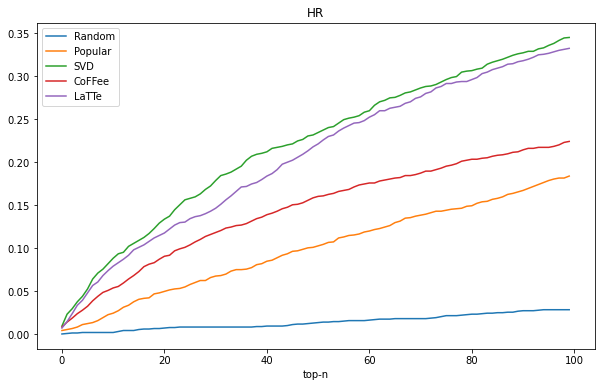

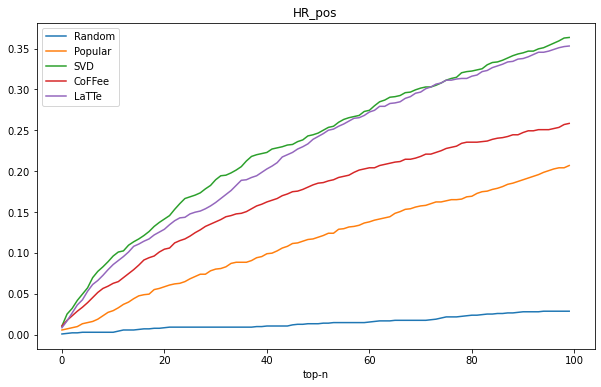

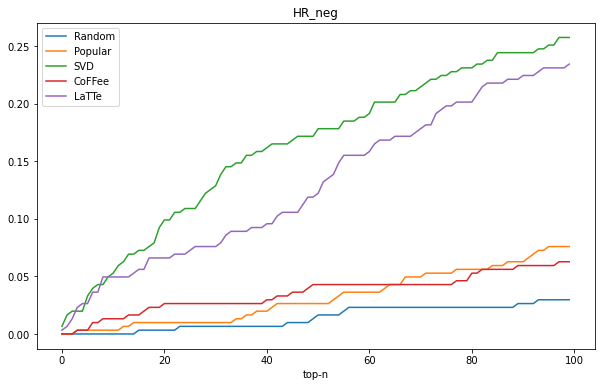

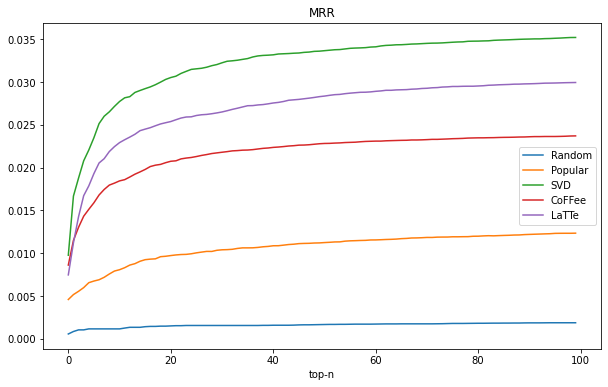

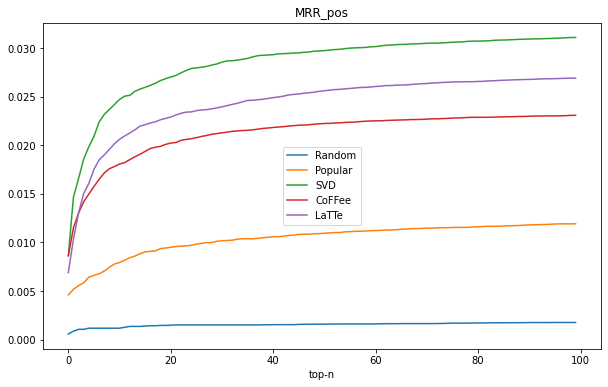

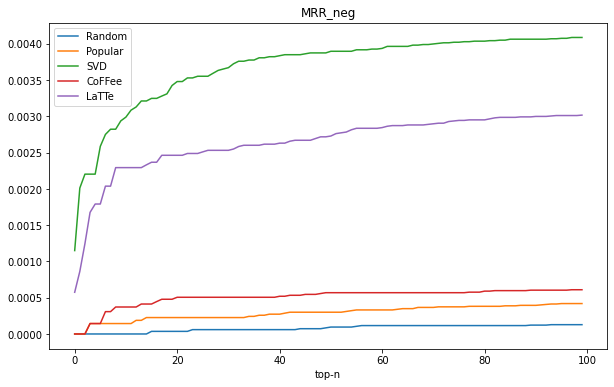

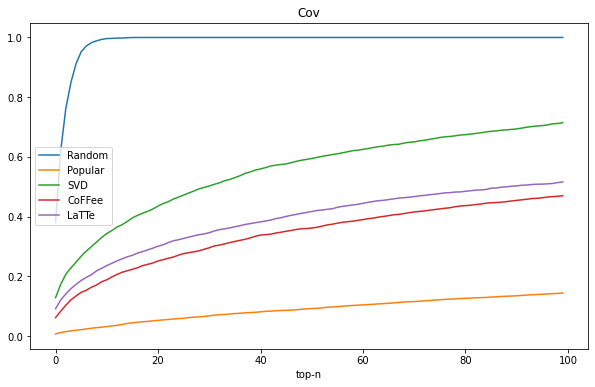

In [18]:
names = ['HR', 'HR_pos', 'HR_neg', 'MRR', 'MRR_pos', 'MRR_neg', 'Cov']
for i in range(7):
    plt.figure(figsize=(10,6))
    plt.title(f'{names[i]}')
    plt.xlabel('top-n')
    plt.plot(rnd_metrics[i], label='Random')
    plt.plot(pop_metrics[i], label='Popular')
    plt.plot(svd_metrics[i], label='SVD')
    plt.plot(cof_metrics[i], label='CoFFee')
    plt.plot(latte_metrics[i], label='LaTTe')
    plt.legend()
    plt.show()